In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1,parser='auto')
mnist.keys()

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print("X.shape :", X.shape)
print("y.shape :", y.shape)

X.shape : (70000, 784)
y.shape : (70000,)


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random

In [4]:
index = random.randint(0, 70000)
some_digit = X.iloc[index].values
some_digit_image = some_digit.reshape(28, 28)

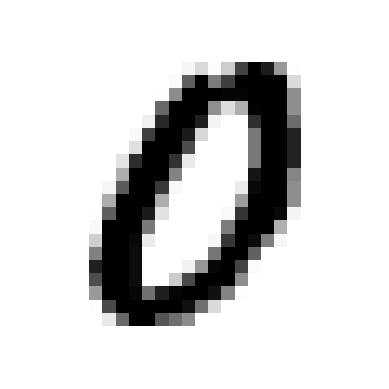

In [5]:
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
y[index]

'0'

In [7]:
import numpy as np

y = y.astype(np.uint8)

In [8]:
def plot_digits_square(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

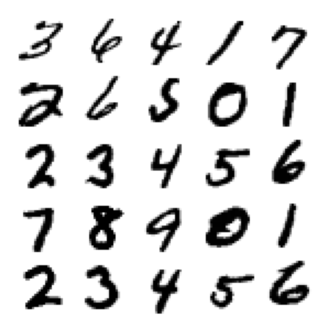

In [9]:
plt.figure(figsize=(4, 4))
example_images = X[-25:].to_numpy(dtype=float)
plot_digits_square(example_images, images_per_row=5)

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
y_train_5 = (y_train == 5) #assigns true for all 5, false otherwise
y_test_5 = (y_test == 5)

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_classifier.predict([some_digit])

C:\Users\SAI TARUN\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([False])

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# We will have 3 folds
skfolds = StratifiedKFold(n_splits=3, shuffle=False)
clone_clf = clone(sgd_classifier)
X_train_np = X_train.to_numpy()
y_train_5_np = y_train_5.to_numpy()
for train_index, test_index in skfolds.split(X_train_np, y_train_5_np):
    X_train_fold = X_train_np[train_index]
    y_train_fold = y_train_5_np[train_index]
    X_test_fold = X_train_np[test_index]
    y_test_fold = y_train_5_np[test_index]
    
    clone_clf.fit(X_train_fold, y_train_fold)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print("Accuracy of the fold: ", n_correct/len(y_pred))

Accuracy of the fold:  0.95035
Accuracy of the fold:  0.96035
Accuracy of the fold:  0.9604


In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
from sklearn.model_selection import cross_val_score

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)

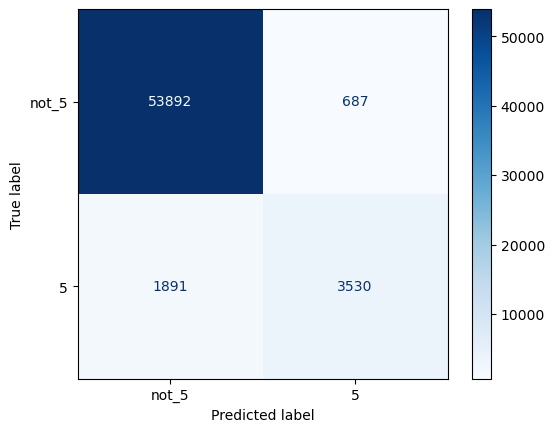

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

#ConfusionMatrixDisplay(sgd_classifier, X_train, y_train_5, values_format="d", cmap=plt.cm.Blues,display_labels=['not_5', '5'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not_5', '5'])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.show()

In [20]:
y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [21]:
from sklearn.metrics import precision_score, recall_score

print("Precision score:", precision_score(y_train_5, y_train_pred))
print("Racall score:", recall_score(y_train_5, y_train_pred))

Precision score: 0.8370879772350012
Racall score: 0.6511713705958311


In [22]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [23]:
y_scores = sgd_classifier.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[-1924.68800867]
[False]


C:\Users\SAI TARUN\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [24]:
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3, method="decision_function")

In [25]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

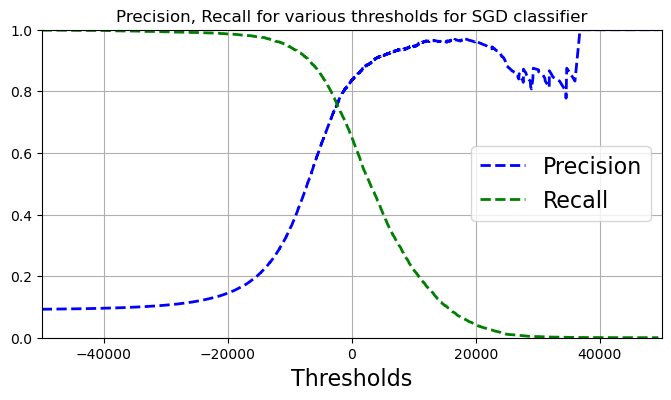

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, title):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Thresholds", fontsize=16)
    plt.title(title)
    plt.axis([-50000, 50000, 0, 1])


plt.figure(figsize=(8,4))
plt.grid(True)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, 
                                   "Precision, Recall for various thresholds for SGD classifier")

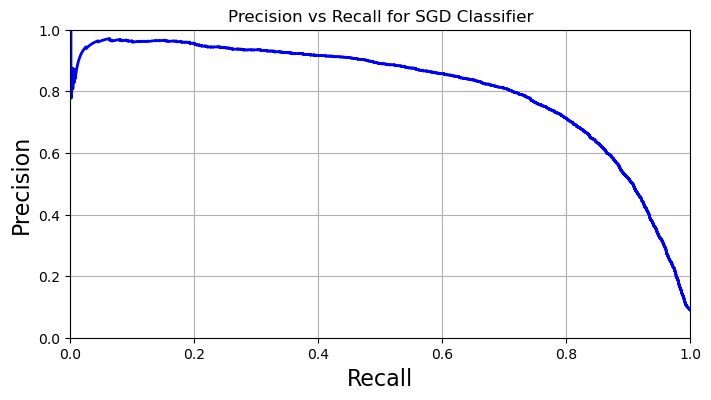

In [27]:
def plot_precision_vs_recall(precisions, recalls, title):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.title(title)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8,4))
plot_precision_vs_recall(precisions, recalls, "Precision vs Recall for SGD Classifier")

In [28]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [29]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print("Precision: ", precision_score(y_train_5, y_train_pred_90))
print("Recall: ", recall_score(y_train_5, y_train_pred_90))

Precision:  0.9000345901072293
Recall:  0.4799852425751706


In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

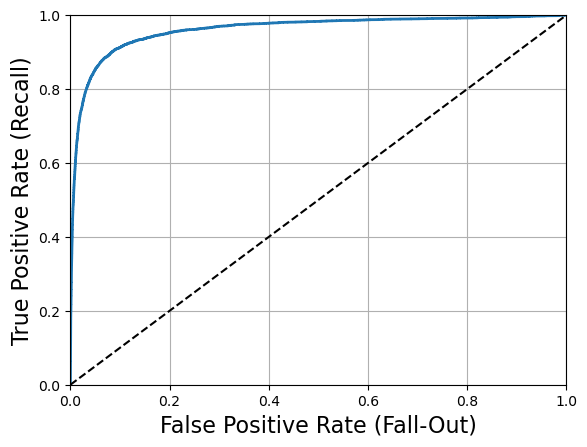

<Figure size 800x600 with 0 Axes>

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])                              
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            
    

plot_roc_curve(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.show()

In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [34]:
y_probas_forest[0], y_train_5[0]

(array([0.11, 0.89]), True)

In [35]:
y_scores_forest = y_probas_forest[:, 1] # second column represents positive class's proba
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

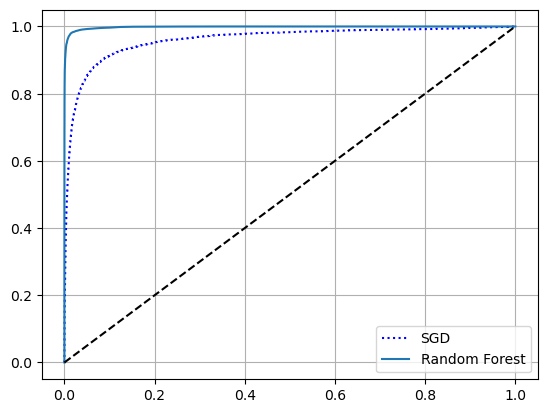

<Figure size 800x600 with 0 Axes>

In [36]:
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, label="Random Forest")
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc="lower right")
plt.grid(True)
plt.figure(figsize=(8, 6))
plt.show()

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [38]:
from sklearn.metrics import precision_recall_curve
precisions_rf, recalls_rf, thresholds_rf = precision_recall_curve(y_train_5, y_scores_forest)

<Figure size 800x400 with 0 Axes>

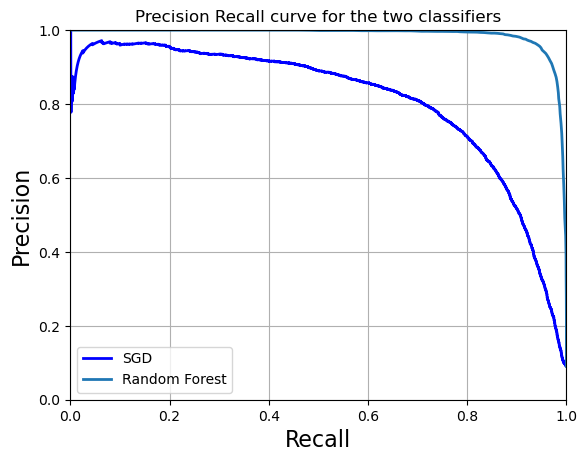

<Figure size 800x400 with 0 Axes>

In [39]:
plt.plot(recalls, precisions, "b-", linewidth=2, label="SGD")
plt.plot(recalls_rf, precisions_rf, linewidth=2, label="Random Forest")
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.title("Precision Recall curve for the two classifiers")
plt.legend(loc="lower left")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.figure(figsize=(8,4))

In [40]:
threshold_99_precision = thresholds_rf[np.argmax(precisions_rf >= 0.99)]
threshold_99_precision

0.51

In [41]:
y_train_pred_99 = (y_scores_forest >= threshold_99_precision)
print("Precision: ", precision_score(y_train_5, y_train_pred_99))
print("Recall: ", recall_score(y_train_5, y_train_pred_99))

Precision:  0.9905083315756169
Recall:  0.8662608374838591
